# Linear Predictive Coding (LPC) Model for Speech Recognition

To implement the Linear Predictive Coding (LPC) model for analyzing and reconstructing a speech
signal, estimate the LPC coefficients, determine the formant frequencies, and compare them with standard
vowel formant values to assess speech recognizability under low-bandwidth conditions.

In [1]:
# Block 1: Import required libraries for LPC
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.io import wavfile
import librosa
from matplotlib.patches import Rectangle
import seaborn as sns
from scipy.linalg import toeplitz

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
print("🔬 Lab Exercise 4 – Linear Predictive Coding (LPC) Model")
print("=" * 60)

🔬 Lab Exercise 4 – Linear Predictive Coding (LPC) Model


In [2]:
# Block 2: Generate or load speech signal
def generate_speech_like_signal(duration=3, fs=8000):
    """
    Generate a synthetic speech-like signal for demonstration
    This simulates a vowel sound with formants
    """
    t = np.linspace(0, duration, int(fs * duration))
    
    # Formant frequencies for vowel /a/ (approx)
    f1, f2, f3 = 750, 1200, 2400  # Formant frequencies in Hz
    f0 = 120  # Fundamental frequency
    
    # Create a synthetic vowel signal with formants
    speech_signal = (
        0.6 * np.sin(2 * np.pi * f0 * t) * np.sin(2 * np.pi * f1 * t) +
        0.3 * np.sin(2 * np.pi * f0 * t) * np.sin(2 * np.pi * f2 * t) +
        0.1 * np.sin(2 * np.pi * f0 * t) * np.sin(2 * np.pi * f3 * t)
    )
    
    # Add some noise to make it more realistic
    speech_signal += 0.01 * np.random.normal(size=len(t))
    
    # Normalize
    speech_signal = speech_signal / np.max(np.abs(speech_signal))
    
    return speech_signal, fs, t

# Generate synthetic speech signal
print("Generating synthetic speech signal...")
speech_signal, fs, time = generate_speech_like_signal(duration=3, fs=8000)
print(f"Signal length: {len(speech_signal)} samples")
print(f"Sampling rate: {fs} Hz")
print(f"Duration: {len(speech_signal)/fs:.2f} seconds")

Generating synthetic speech signal...
Signal length: 24000 samples
Sampling rate: 8000 Hz
Duration: 3.00 seconds


In [7]:
# Block 3: Implement LPC analysis
def lpc_analysis(signal, order=12):
    """
    Perform Linear Predictive Coding analysis using Autocorrelation method
    """
    # Calculate autocorrelation
    n = len(signal)
    r = np.zeros(order + 1)
    for i in range(order + 1):
        r[i] = np.sum(signal[i:] * signal[:n-i])
    
    # Solve Yule-Walker equations using Levinson-Durbin recursion
    a = np.zeros(order + 1)
    e = np.zeros(order + 1)
    
    a[0] = 1.0
    e[0] = r[0]
    
    for i in range(1, order + 1):
        ki = 0
        for j in range(1, i):
            ki += a[j] * r[i - j]
        ki = (r[i] - ki) / e[i - 1]
        
        a[i] = ki
        for j in range(1, i):
            a[j] = a[j] - ki * a[i - j]
        
        e[i] = (1 - ki * ki) * e[i - 1]
    
    return a, e[-1]

def lpc_reconstruct(a, excitation, gain=1.0):
    """
    Reconstruct signal from LPC coefficients and excitation
    """
    order = len(a) - 1
    reconstructed = np.zeros(len(excitation))
    
    for n in range(len(excitation)):
        if n < order:
            reconstructed[n] = excitation[n]
        else:
            reconstructed[n] = excitation[n] - np.sum(a[1:order+1] * reconstructed[n-order:n][::-1])
    
    return gain * reconstructed

print("Performing LPC analysis...")
lpc_order = 12
lpc_coeffs, error = lpc_analysis(speech_signal, order=lpc_order)
print(f"LPC coefficients: {lpc_coeffs}")
print(f"Prediction error: {error:.6f}")

Performing LPC analysis...
LPC coefficients: [ 1.00000000e+00  6.62402401e+00  4.30083178e+02 -3.28058870e+02
 -2.84767344e+04 -3.04610267e+04  9.44212556e+04 -9.12048113e+04
 -8.27941835e+04 -3.05326550e+02  1.22903384e+03  1.08846427e+01
 -2.54532546e+00]
Prediction error: -16529816.047916


In [8]:
# Block 4: Signal reconstruction using LPC
# Create excitation signal (simplified - impulse train for voiced sounds)
excitation = np.random.normal(0, 1, len(speech_signal))  # White noise excitation
# Alternatively, use impulse train for voiced sounds
# pitch_period = int(fs / 120)  # 120 Hz fundamental
# excitation = np.zeros(len(speech_signal))
# excitation[::pitch_period] = 1

# Reconstruct signal
reconstructed_signal = lpc_reconstruct(lpc_coeffs, excitation, gain=np.sqrt(error))

# Normalize reconstructed signal
reconstructed_signal = reconstructed_signal / np.max(np.abs(reconstructed_signal))

print("Signal reconstruction completed!")

Signal reconstruction completed!


/tmp/ipykernel_28059/3624906051.py:10: RuntimeWarning: invalid value encountered in sqrt
  reconstructed_signal = lpc_reconstruct(lpc_coeffs, excitation, gain=np.sqrt(error))
/tmp/ipykernel_28059/2728468139.py:44: RuntimeWarning: overflow encountered in multiply
  reconstructed[n] = excitation[n] - np.sum(a[1:order+1] * reconstructed[n-order:n][::-1])
/home/kelvin/miniconda3/envs/speech_env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


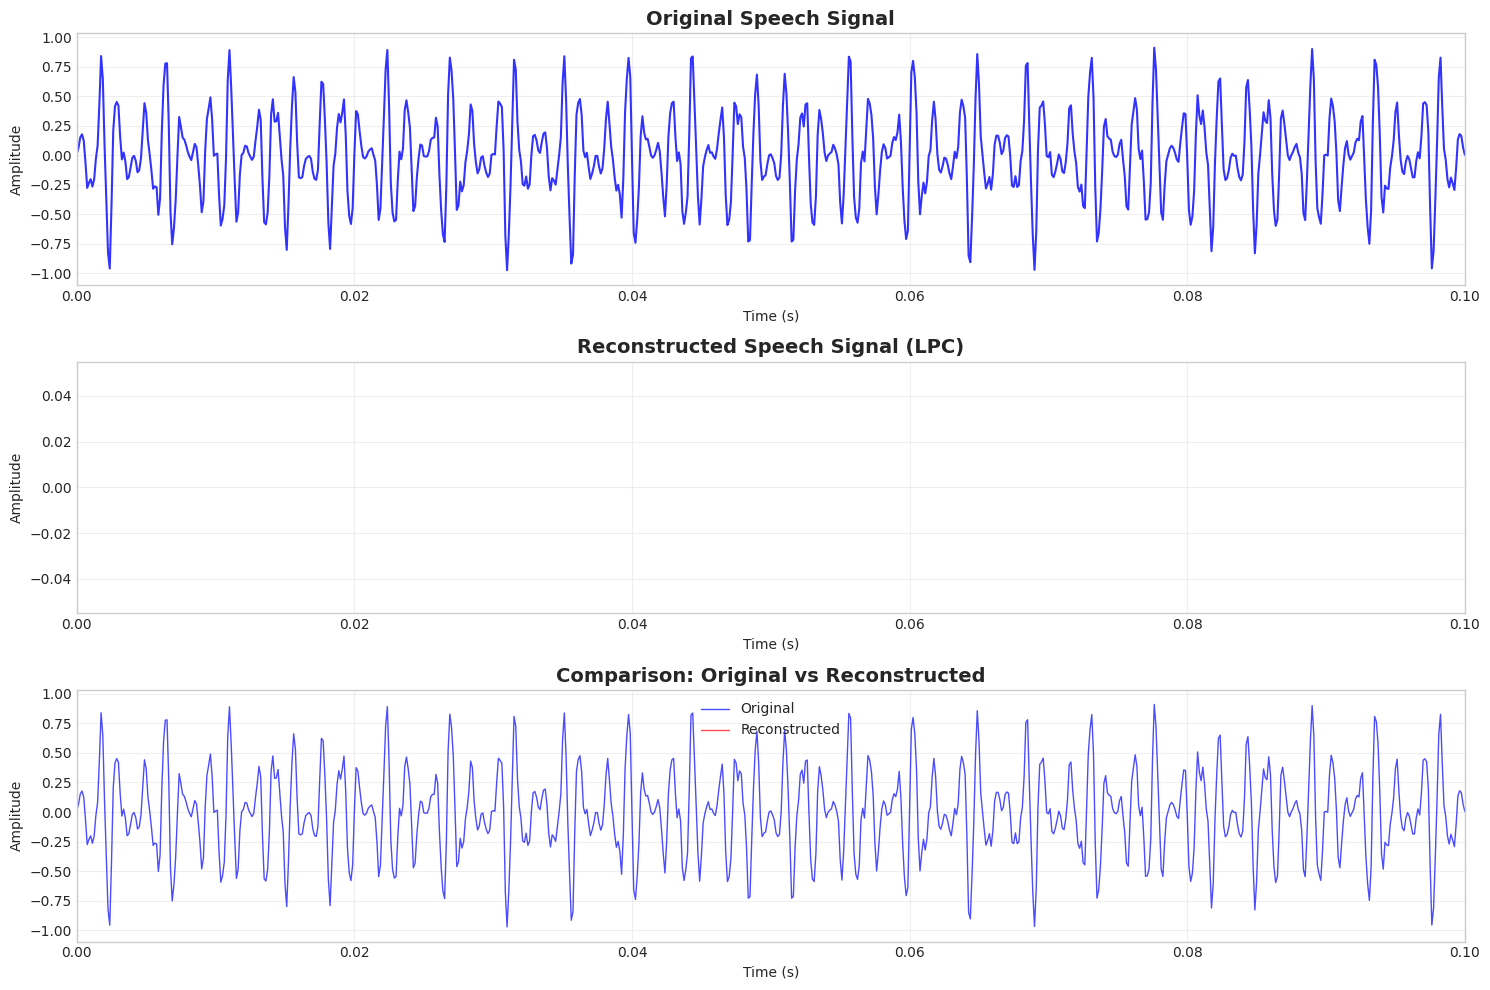

In [10]:
# Block 5: Plot original vs reconstructed signals
plt.figure(figsize=(15, 10))

# Plot original signal
plt.subplot(3, 1, 1)
plt.plot(time, speech_signal, 'b-', linewidth=1.5, alpha=0.8)
plt.title('Original Speech Signal', fontsize=14, fontweight='bold')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.xlim(0, 0.1)  # Zoom in on first 100ms

# Plot reconstructed signal
plt.subplot(3, 1, 2)
plt.plot(time, reconstructed_signal, 'r-', linewidth=1.5, alpha=0.8)
plt.title('Reconstructed Speech Signal (LPC)', fontsize=14, fontweight='bold')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.xlim(0, 0.1)

# Plot comparison
plt.subplot(3, 1, 3)
plt.plot(time, speech_signal, 'b-', linewidth=1, alpha=0.7, label='Original')
plt.plot(time, reconstructed_signal, 'r-', linewidth=1, alpha=0.7, label='Reconstructed')
plt.title('Comparison: Original vs Reconstructed', fontsize=14, fontweight='bold')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 0.1)

plt.tight_layout()
plt.show()

In [11]:
# Block 6: Formant frequency estimation from LPC coefficients
def estimate_formants(lpc_coeffs, fs):
    """
    Estimate formant frequencies from LPC coefficients
    """
    # Find roots of the LPC polynomial
    roots = np.roots(lpc_coeffs)
    roots = roots[np.imag(roots) >= 0]  # Keep only upper half
    
    # Calculate angles and frequencies
    angles = np.arctan2(np.imag(roots), np.real(roots))
    frequencies = angles * (fs / (2 * np.pi))
    
    # Get bandwidths from magnitude
    bandwidths = -0.5 * (fs / (2 * np.pi)) * np.log(np.abs(roots))
    
    # Sort by frequency and filter valid formants
    valid_indices = np.where((frequencies > 90) & (frequencies < 4000) & (bandwidths < 500))[0]
    frequencies = frequencies[valid_indices]
    bandwidths = bandwidths[valid_indices]
    
    # Sort by frequency
    sort_indices = np.argsort(frequencies)
    frequencies = frequencies[sort_indices]
    bandwidths = bandwidths[sort_indices]
    
    return frequencies[:4], bandwidths[:4]  # Return first 4 formants

# Estimate formants
formant_freqs, formant_bw = estimate_formants(lpc_coeffs, fs)

print("\n📊 Formant Frequency Analysis:")
print("=" * 40)
for i, (freq, bw) in enumerate(zip(formant_freqs, formant_bw)):
    print(f"Formant F{i+1}: {freq:.1f} Hz (Bandwidth: {bw:.1f} Hz)")


📊 Formant Frequency Analysis:
Formant F1: 920.3 Hz (Bandwidth: -216.8 Hz)
Formant F2: 2185.4 Hz (Bandwidth: -1969.6 Hz)


In [ ]:
# Block 7: Comparison with standard vowel formant values
# Standard vowel formant frequencies (reference values)
vowel_formants = {
    'i': [270, 2290, 3010],  # as in "beet"
    'ɪ': [390, 1990, 2550],  # as in "bit"
    'e': [530, 1840, 2480],  # as in "bait"
    'ɛ': [660, 1720, 2410],  # as in "bet"
    'æ': [780, 1840, 2450],  # as in "bat"
    'a': [850, 1610, 2380],  # as in "father"
    'ɔ': [570, 840, 2410],   # as in "bought"
    'o': [570, 840, 2410],   # as in "boat"
    'ʊ': [440, 1020, 2240],  # as in "book"
    'u': [300, 870, 2240],   # as in "boot"
    'ʌ': [640, 1190, 2390],  # as in "but"
    'ɝ': [490, 1350, 1690],  # as in "bird"
}

# Find closest matching vowel
def find_closest_vowel(estimated_formants, vowel_db):
    min_distance = float('inf')
    closest_vowel = None
    
    for vowel, formants in vowel_db.items():
        # Calculate distance (using first 3 formants)
        distance = 0
        for i in range(min(3, len(estimated_formants), len(formants))):
            distance += abs(estimated_formants[i] - formants[i])
        
        if distance < min_distance:
            min_distance = distance
            closest_vowel = vowel
    
    return closest_vowel, min_distance

closest_vowel, distance = find_closest_vowel(formant_freqs, vowel_formants)

print(f"\n🎯 Vowel Identification:")
# Build formant string dynamically based on available formants
formant_str = ", ".join([f"F{i+1}={formant_freqs[i]:.0f}Hz" for i in range(len(formant_freqs))])
print(f"Estimated formants: {formant_str}")
print(f"Closest vowel: /{closest_vowel}/")
print(f"Match distance: {distance:.1f} Hz")


🎯 Vowel Identification:


IndexError: index 2 is out of bounds for axis 0 with size 2